In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
# Mappings for utility
MAP_PERCENT_TO_AMOUNT = {
    "10" : 280,
    "25" : 700,
    "50" : 1400,
    "100": 2799
}

DAMAGE_LEVEL_TO_SCORE = {
    "destroyed" : 4,
    "major-damage" : 3,
    "minor-damage" : 2,
    "no-damage" : 1,
}

TRAIN_SET_SIZE = MAP_PERCENT_TO_AMOUNT["10"]

In [3]:
DATASET_FOLDER_PATH = os.path.join("..","dataset")
XVIEW2_TXT_FILE = os.path.join("..","data","xview2.txt")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Baseline model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(512, num_classes)

        

    def forward(self, x):
        x = self.resnet(x)
        return x
    
    def train_model(self, dataloader, num_epochs=10, lr=0.001, momentum=0.9):
        self.train()
        self.to(device)

        optimizer = torch.optim.SGD(self.parameters(), lr, momentum)
        criterion = nn.CrossEntropyLoss()
        # Train the model

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in dataloader:
                images, labels =  images.to(device),labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = self(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimizatio.n
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")
            torch.save(self.state_dict(), 'resnet_classifier.pth')
    # Define the evaluation function
    def evaluate_model(self, test_dataloader):
        self.eval()  # Set the model to evaluation mode
        self.to(device)

        correct = 0
        total = 0

        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                true_labels.extend(labels.numpy())
                predicted_labels.extend(predicted.numpy())

        accuracy = correct / total
        confusion_mat = confusion_matrix(true_labels, predicted_labels)


        return accuracy, confusion_mat

In [5]:
# Get predefined training samples for the seminar
def get_training_set_entries(amount=280):
    xview_file = open(XVIEW2_TXT_FILE,'r')
    return xview_file.read().splitlines()[:amount]

In [6]:
# Get mean and standard deviation of dataset
# This is needed for normalization
def calc_mean_and_std_of_dataset(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    
    return mean, std

Normalize Dataset

In [7]:
# Load and preprocess your dataset using torchvision.transforms
pre_norm_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the input image to match the expected size of ResNet (224x224)
    transforms.ToTensor()
])
# Calculate the mean and standard deviation of your dataset
path_to_dataset = os.path.join(DATASET_FOLDER_PATH,"train")
dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform=pre_norm_transform)
data_point_names = get_training_set_entries(amount = TRAIN_SET_SIZE)

subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in data_point_names]
loader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

mean, std = calc_mean_and_std_of_dataset(loader=loader)

Setup training model

In [8]:


# Update the normalization transform using your dataset's mean and standard deviation
transform = transforms.Compose([
    pre_norm_transform,
    transforms.Normalize(mean, std)
])

# Example dataset loading using torchvision.datasets.ImageFolder
dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform=transform)
subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in data_point_names]
dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True)

Train model

In [9]:
# Train the model
num_classes = 5  # Number of output classes
model = ResNetClassifier(num_classes)

model.train_model(dataloader=dataloader, num_epochs=5)
# Save the trained model
torch.save(model.state_dict(), 'resnet_classifier.pth')


Epoch 1/5, Loss: 13.22907292842865
Epoch 2/5, Loss: 12.361014246940613
Epoch 3/5, Loss: 12.00230848789215
Epoch 4/5, Loss: 11.686609864234924
Epoch 5/5, Loss: 11.156983733177185


Setup evaluating test performance

In [10]:

test_dataset = torchvision.datasets.ImageFolder(os.path.join("..","dataset","test"), transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Evaluate model on test data

In [11]:


#Load the saved model state dictionary
#model = ResNetClassifier(num_classes)
#model.load_state_dict(torch.load('resnet_classifier.pth'))

# Evaluate the model
accuracy, confusion_mat = model.evaluate_model(test_dataloader=test_dataloader)

# Print the accuracy
print(f"Accuracy: {accuracy}")

print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.5144694533762058
Confusion Matrix:
[[124  70   0   0   0]
 [ 45 349   2   1   0]
 [ 25 112   0   1   0]
 [ 36  75   1   7   0]
 [ 27  58   0   0   0]]


Visualize Results

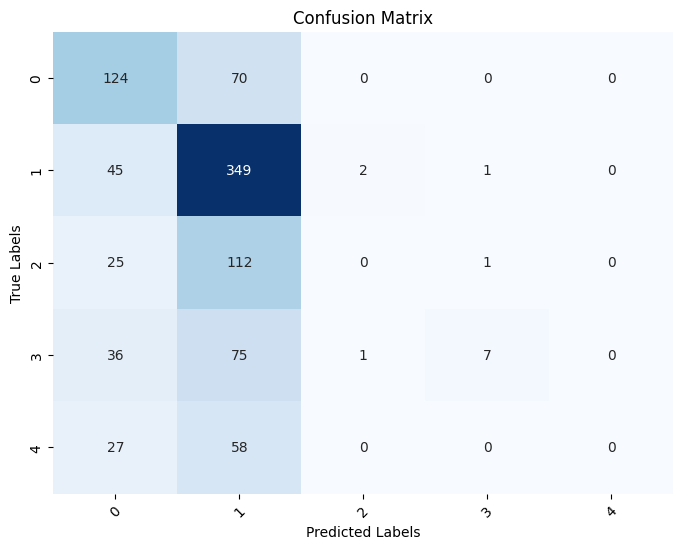

In [12]:
# Get the class labels
class_labels = test_dataset.classes

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()